In [1]:
import collections
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

import generate_dataset
from multiobject import generate_multiobject_dataset, iterate_video_dataset
from sprites import generate_dsprites, generate_binary_mnist, generate_simiansprites
from utils import get_date_str, show_img_grid

In [2]:
DELTA_T = 0.015
DISTANCE_TO_SCREEN = 106
FPS = 60
HOLD_DEGREES = 2
SCALE_MOVIE = 1
SCREEN_DIMS = (100, 62)
SCREEN_RES = (1920, 1080)
SCALED_VIDEO_RES = (SCREEN_RES[0], SCREEN_RES[1])
SPRITE_RES = (280, 280)
VIDEO_SECONDS = 5
VIDEO_RES = SCREEN_RES
VIDEO_THRESHOLDS = [
    [(SCREEN_RES[0] - SCALED_VIDEO_RES[0]) / 2, (SCREEN_RES[1] - SCALED_VIDEO_RES[1]) / 2],
    [(SCREEN_RES[0] + SCALED_VIDEO_RES[0]) / 2, (SCREEN_RES[1] + SCALED_VIDEO_RES[1]) / 2]
]

In [3]:
SCREEN_HALFWIDTH_DEGREES = np.degrees(np.arctan(SCREEN_DIMS[0] / 2 / DISTANCE_TO_SCREEN))
SCREEN_HALFHEIGHT_DEGREES = np.degrees(np.arctan(SCREEN_DIMS[1] / 2 / DISTANCE_TO_SCREEN))

In [4]:
def xdegrees_to_coords(theta):
    return theta / SCREEN_HALFWIDTH_DEGREES

def ydegrees_to_coords(theta):
    return theta / SCREEN_HALFHEIGHT_DEGREES

def rfs_to_normalized_coords(rfs):
    for (x, y, rx, ry, theta) in rfs:
        x, rx = xdegrees_to_coords(x), xdegrees_to_coords(rx + HOLD_DEGREES)
        y, ry = ydegrees_to_coords(y), ydegrees_to_coords(ry + HOLD_DEGREES)
        yield (x, y, rx, ry, theta)

In [5]:
VIDEOS_PER_SPRITE = 4
TIMESTEPS = VIDEO_SECONDS * FPS

In [6]:
sprites, attrs = generate_simiansprites(SPRITE_RES[0])

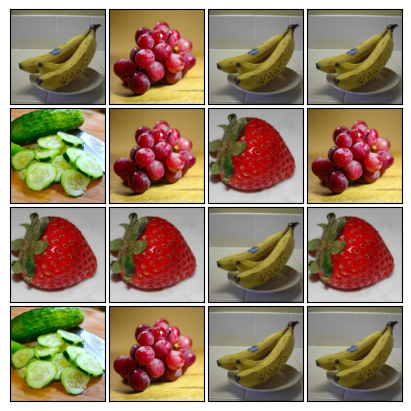

In [7]:
# Show sprites
show_img_grid(4, sprites, random_selection=True)

In [8]:
ch = sprites[0].shape[-1]
img_shape = (*SCREEN_RES, ch)

In [9]:
COUNTS = collections.Counter({k: VIDEOS_PER_SPRITE for k in attrs['labels']})

In [10]:
RFS = [(1.1956, -0.8998, 7.7807 / 10, 8.3316 / 10, 71.9597),
       (1.6323, -0.3723, 7.9996 / 10, 7.7847 / 10, 66.3772)]

In [11]:
generator = iterate_video_dataset(VIDEOS_PER_SPRITE * sprites.shape[0], img_shape, sprites,
                                  attrs, COUNTS, VIDEO_SECONDS * FPS, DELTA_T,
                                  allow_overlap=True, rfs=list(rfs_to_normalized_coords(RFS)))

In [12]:
GENERATED_PATH = 'generated/simiansprites/full/'

In [13]:
if not os.path.exists(GENERATED_PATH):
    os.makedirs(GENERATED_PATH)

In [14]:
fruit_types = collections.Counter()

In [15]:
for v, (video, _, labels) in enumerate(generator):
    label = labels['labels']
    label_count = fruit_types[label]
    video_fname = GENERATED_PATH + label + str(label_count)
    fruit_types[label] += 1
    video.write(FPS, video_fname)

num sprites: 4


100%|███████████████████████████████████████████| 16/16 [12:51<00:00, 48.22s/it]
